In [10]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
import glob

In [11]:
# Helper functions
def BGR2RGB(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def DisplayImage(img, title):
    plt.figure()
    plt.imshow(BGR2RGB(img))
    plt.title(title)

## Undistort Chessboard Images

In [15]:
def CalibrateImages(images, patternSize = (9, 6)):
    imgpoints = []
    objpoints = []
    calibrated = []
    imgshape = None
    termCriteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Iterate through each chessboard image
    for imagePath in images:
        img = cv.imread(imagePath)
        imgshape = (img.shape[0], img.shape[1])

        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Find chessboard corners
        success, corners = cv.findChessboardCorners(gray, patternSize, None)
        if success:
            cornerSP = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), termCriteria)
            imgpoints.append(corners)

            # Calculate object pattern
            objPattern = np.zeros((patternSize[1] * patternSize[0], 3), np.float32)
            objPattern[:, :2] = np.mgrid[0:patternSize[0], 0:patternSize[1]].T.reshape(-1, 2)
            objpoints.append(objPattern)
            
            # Display the corners
            cv.drawChessboardCorners(img, patternSize, cornerSP, success)
            calibrated.append(img)
        else:
            # Conclude that the algorithm cannot find the corners in this photo
            print("Could not find corners in " + imagePath)

    # Calculate camera matrix and dist
    ret, matrix, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, imgshape, None, None)
    return calibrated, matrix, dist

Could not find corners in materials/camera_cal/calibration5.jpg
Could not find corners in materials/camera_cal/calibration4.jpg
Could not find corners in materials/camera_cal/calibration1.jpg


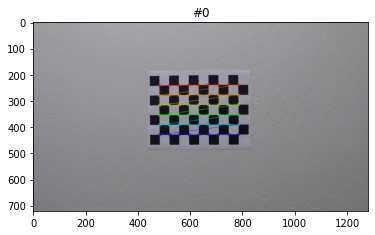

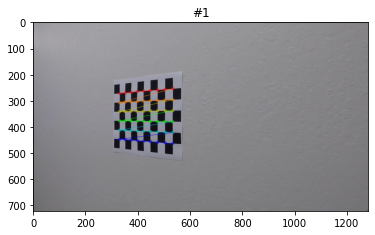

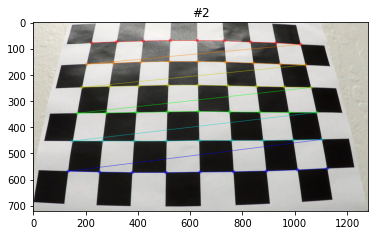

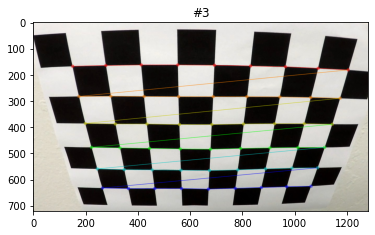

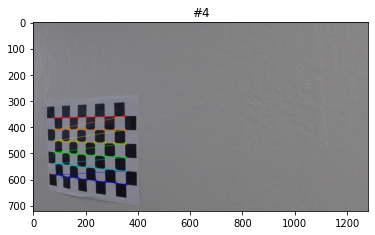

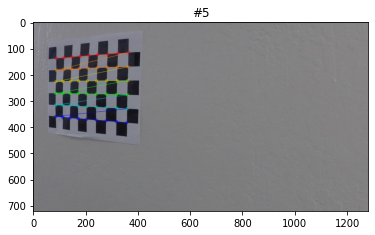

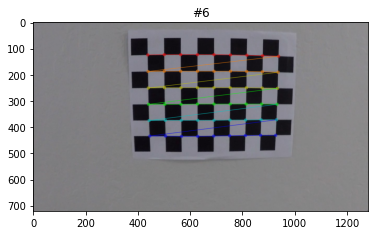

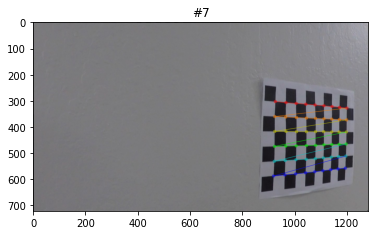

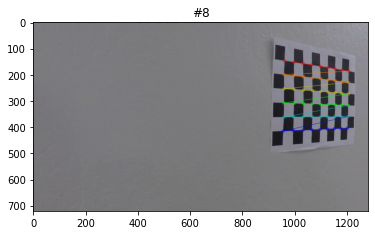

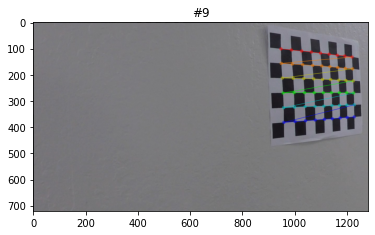

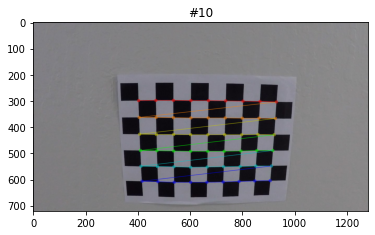

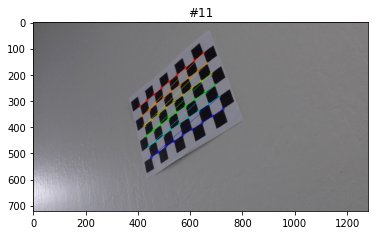

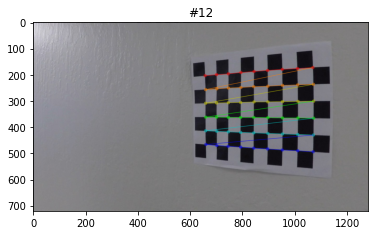

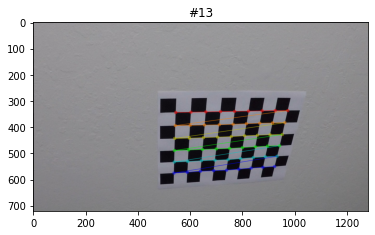

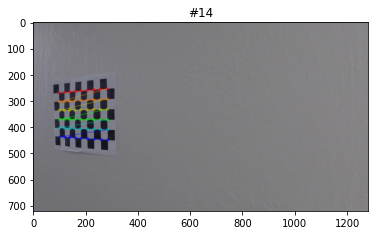

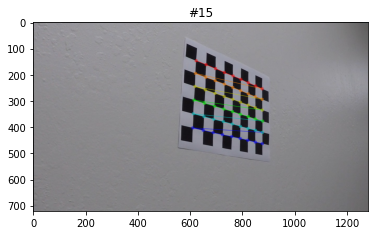

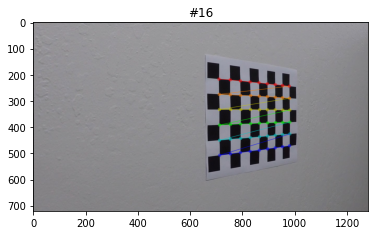

In [16]:
image_paths = glob.glob('materials/camera_cal/calibration*.jpg')
calibrated, matrix, dist = CalibrateImages(image_paths)

# Display calibrated images
for i, img in enumerate(calibrated):
    DisplayImage(img, "#" + str(i))

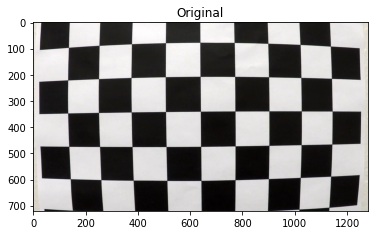

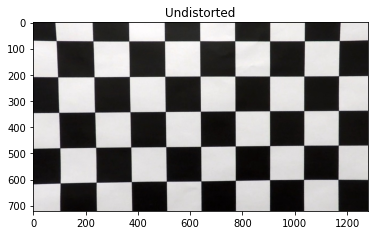

In [17]:
# Undistort calibrated images
def undistort(image, matrix, dist):
    return cv.undistort(image, matrix, dist, None, matrix)

# Undistort test image
chessboard = cv.imread("materials/camera_cal/calibration1.jpg")
undistorted = undistort(chessboard, matrix, dist)
DisplayImage(chessboard, "Original")
DisplayImage(undistorted, "Undistorted")